# 멀티 에이전트 관리자

[이전 예제](../multi-agent-collaboration)에서는 초기 연구원 에이전트의 출력을 기반으로 메시지를 자동으로 라우팅했습니다.

[LLM을 사용하여](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) 여러 에이전트를 오케스트레이션할 수도 있습니다.

아래에서는 에이전트 그룹을 만들고, 태스크를 위임하는 데 도움을 줄 에이전트 관리자를 만들 것입니다.

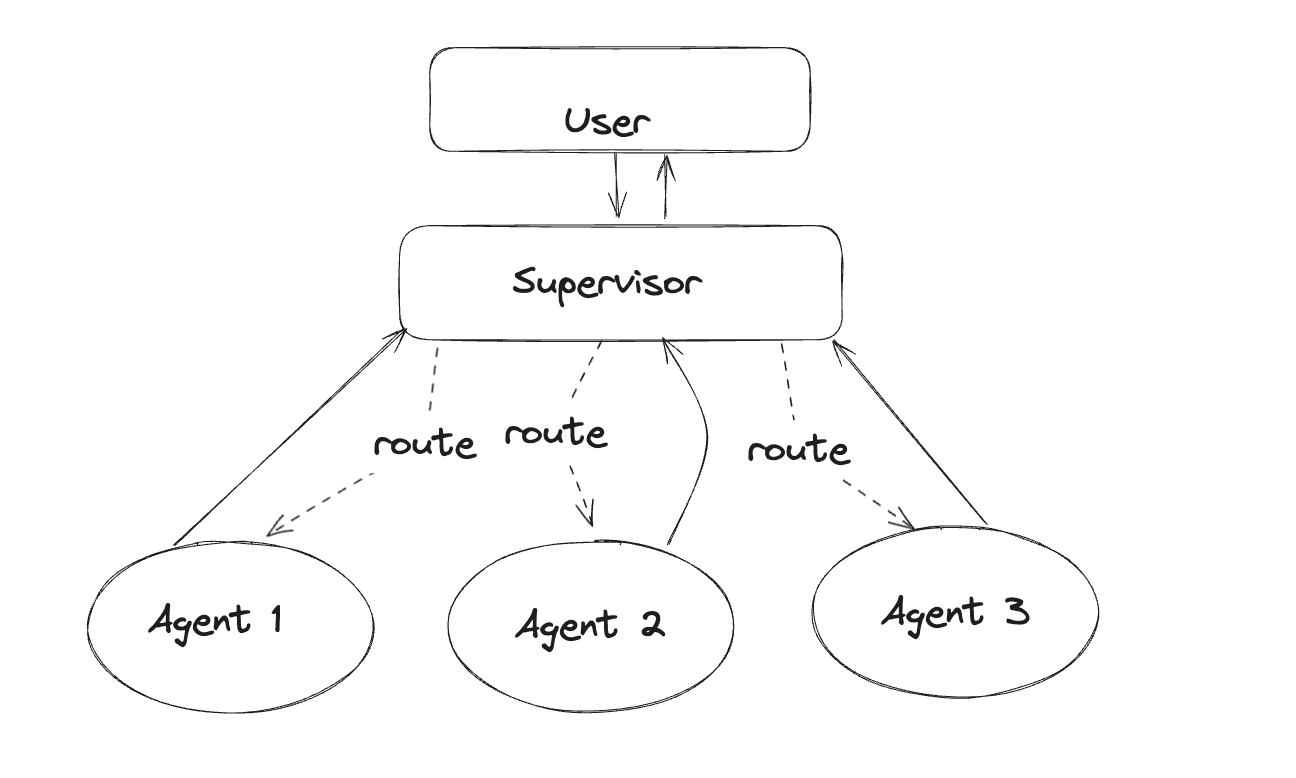

각 에이전트 노드의 코드를 단순화하기 위해 LangGraph에서 미리 빌드한 [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)를 사용합니다. 이 노트북과 다른 에이전트" 노트북은 LangGraph에서 특정 디자인 패턴을 구현하는 방법을 보여주기 위해 만들어졌습니다. 패턴이 필요에 맞는 경우, 최상의 성능을 위해 문서의 다른 곳에 설명된 다른 기본 패턴과 결합하는 것이 좋습니다.

## 설정

먼저 필요한 패키지를 설치하고 API 키를 설정합니다.

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental langchain_google_vertexai

In [4]:
import getpass  # getpass를 import합니다.
import os  # os를 import합니다.


def _set_if_undefined(var: str):  # 환경 변수가 설정되지 않은 경우 설정하는 함수를 정의합니다.
    if not os.environ.get(var):  # 환경 변수가 설정되어 있는지 확인합니다.
        os.environ[var] = getpass.getpass(f"Please provide your {var}")  # 환경 변수가 설정되지 않은 경우 사용자로부터 입력을 받습니다.


# _set_if_undefined("ANTHROPIC_API_KEY")  # ANTHROPIC_API_KEY 환경 변수를 설정합니다.
_set_if_undefined("TAVILY_API_KEY")  # TAVILY_API_KEY 환경 변수를 설정합니다.

<div class="admonition tip">
    <p class="admonition-title">LangGraph 개발을 위해 <a href="https://smith.langchain.com">LangSmith</a>를 설정하세요</p>
    <p style="padding-top: 5px;">
        LangSmith에 가입하여 문제를 신속하게 발견하고 LangGraph 프로젝트의 성능을 개선하세요. LangSmith를 사용하면 추적 데이터를 사용하여 LangGraph로 구축된 LLM 앱을 디버그, 테스트 및 모니터링할 수 있습니다. 시작하는 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">여기</a>에서 확인하세요.
    </p>
</div>

## 도구 생성

이 예제에서는 검색 엔진으로 웹 연구를 수행하는 에이전트와 플롯을 생성하는 에이전트를 만들 것입니다. 아래에서 사용할 도구를 정의합니다.

In [5]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

### 에이전트 관리자 생성

LLM을 사용하여 구조화된 출력을 통해 다음 작업자 노드를 선택하거나 처리를 완료합니다.

In [10]:
from typing import Literal
from typing_extensions import TypedDict

# from langchain_anthropic import ChatAnthropic
from langchain_google_vertexai import ChatVertexAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

    # "당신은 다음 작업자들 간의 대화를 관리하는 감독자입니다: {members}. 다음 사용자 요청이 주어지면,"
    # "다음에 행동할 작업자를 응답하십시오. 각 작업자는 작업을 수행하고 결과와 상태를 응답합니다. 완료되면"
    # "FINISH로 응답하십시오."

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
# Literal[*options]는 미리 정의된 옵션들(researcher, coder, FINISH) 중 하나만 선택할 수 있도록 제한합니다
# 연구가 필요한 경우
# {"next": "researcher"}

# 코딩이 필요한 경우
# {"next": "coder"}

# 모든 작업이 완료된 경우
# {"next": "FINISH"}
    next: Literal[*options]


# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm = ChatVertexAI(model_name="gemini-2.0-flash-001")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

## 그래프 구성

이제 그래프를 구축할 준비가 되었습니다. 아래에서는 앞에서 정의한 함수를 사용하여 상태 및 작업자 노드를 정의합니다.

In [11]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

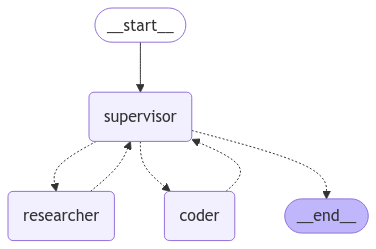

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## 팀 호출

그래프가 생성되었으므로, 이제 그래프를 호출하여 어떻게 작동하는지 확인할 수 있습니다!

In [13]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:35faed1b-b342-ac8c-fa56-7cf35324d4ed',), {'agent': {'messages': [AIMessage(content='I am designed to avoid performing mathematical calculations. Would you like me to find information about the square root of 42 using the search tool?\n', additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 69, 'candidates_token_count': 30, 'total_token_count': 99, 'prompt_tokens_details': [{'modality': 1, 'token_count': 69}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 30}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.0769946018854777}, id='run-09c0a080-cf7e-4bbe-9b5c-eb55c7c6dee4-0', usage_metadata={'input_tokens': 69, 'output_tokens': 30, 'total_tokens': 99})]}})
----
((), {'researcher': {'messages': [HumanMessage(content='I am designed to avoid performing mathematical calculations. Would 

In [14]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----


This model can reply with multiple function calls in one response. Please don't rely on `additional_kwargs.function_call` as only the last one will be saved.Use `tool_calls` instead.


(('researcher:7b66fd6b-a545-d283-8835-20b16d576068',), {'agent': {'messages': [AIMessage(content='I am designed to avoid performing mathematical calculations. Therefore, I will conduct a search to find the latest GDP figures for New York and California. After I have those values, I will return them to you so you can calculate the average.\n\n', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "latest GDP of California"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 72, 'candidates_token_count': 75, 'total_token_count': 147, 'prompt_tokens_details': [{'modality': 1, 'token_count': 72}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 75}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.18102647145589193}, id='run-109ad23d-ebb8-4e3b-b4eb-9986f675cb10-0', tool_calls=[{'name': 'tavily_search_results_json', 'ar

Python REPL can execute arbitrary code. Use with caution.


(('coder:34cbf201-93ee-5483-ec24-7f150f04ec3c',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_repl_tool', 'arguments': '{"code": "new_york_gdp = 1.8e12\\ncalifornia_gdp = 3.2e12\\naverage_gdp = (new_york_gdp + california_gdp) / 2\\nprint(average_gdp)"}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 157, 'candidates_token_count': 63, 'total_token_count': 220, 'prompt_tokens_details': [{'modality': 1, 'token_count': 157}], 'candidates_tokens_details': [{'modality': 1, 'token_count': 63}], 'cached_content_token_count': 0, 'cache_tokens_details': []}, 'finish_reason': 'STOP', 'avg_logprobs': -0.006672678958801996}, id='run-77b48a10-c8a4-4cab-ae11-97469678b85c-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'new_york_gdp = 1.8e12\ncalifornia_gdp = 3.2e12\naverage_gdp = (new_york_gdp + california_gdp) / 2\nprint(average_gdp)'}, 'id': '895b42ae-9897-4a4d-97a8-cae1bb